In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import Imputer
from sklearn import linear_model
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn import svm
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import make_scorer, r2_score
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
import tflearn
import tensorflow as tf
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [2]:
'''
Pre-process is referred from: https://www.kaggle.com/miguelangelnieto/pca-and-regression/notebook/notebook
'''
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
labels = train["SalePrice"]
data = pd.concat([train, test], ignore_index=True)

In [3]:
print(data.shape)
print(data.dtypes.value_counts())

(2919, 81)
object     43
int64      26
float64    12
dtype: int64


In [4]:
print(labels.describe())

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


In [5]:
data.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,856,854,0,NaN,3,1Fam,TA,No,706.0,0.0,...,WD,0,Pave,8,856.0,AllPub,0,2003,2003,2008
1,1262,0,0,NaN,3,1Fam,TA,Gd,978.0,0.0,...,WD,0,Pave,6,1262.0,AllPub,298,1976,1976,2007
2,920,866,0,NaN,3,1Fam,TA,Mn,486.0,0.0,...,WD,0,Pave,6,920.0,AllPub,0,2001,2002,2008
3,961,756,0,NaN,3,1Fam,Gd,No,216.0,0.0,...,WD,0,Pave,7,756.0,AllPub,0,1915,1970,2006
4,1145,1053,0,NaN,4,1Fam,TA,Av,655.0,0.0,...,WD,0,Pave,9,1145.0,AllPub,192,2000,2000,2008


In [6]:
data = data.drop("SalePrice", 1)
ids = test['Id']

In [7]:
# Remove id and columns with more than a thousand missing values
data = data.drop("Id", 1)
data = data.drop("Alley", 1)
data = data.drop("Fence", 1)
data = data.drop("MiscFeature", 1)
data = data.drop("PoolQC", 1)
data = data.drop("FireplaceQu", 1)

In [8]:
# Count the column types
all_columns = data.columns.values
non_categorical = ["LotFrontage", "LotArea", "MasVnrArea", "BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF",
                   "1stFlrSF", "2ndFlrSF", "LowQualFinSF", "GrLivArea", "GarageArea", "WoodDeckSF", "OpenPorchSF",
                   "EnclosedPorch", "3SsnPorch", "ScreenPorch","PoolArea", "MiscVal"]
categorical = [value for value in all_columns if value not in non_categorical]

In [9]:
# One Hot Encoding and nan transformation
data = pd.get_dummies(data)
imp = Imputer(missing_values="NaN", strategy="most_frequent", axis=0)
data = imp.fit_transform(data)

In [10]:
# log transform
data = np.log(data)
labels = np.log(labels)
data[data == -np.inf] = 0

In [11]:
def lets_try(train, labels):
    results = {}

    def test_model(clf):
        cv = KFold(n_splits=5, shuffle=True, random_state=45)
        r2 = make_scorer(r2_score)
        r2_val_score = cross_val_score(clf, train, labels, cv=cv, scoring=r2)
        scores = [r2_val_score.mean()]
        return scores

    clf = linear_model.LinearRegression()
    results["Linear"] = test_model(clf)

    clf = linear_model.Ridge()
    results["Ridge"] = test_model(clf)

    clf = linear_model.BayesianRidge()
    results["Bayesian Ridge"] = test_model(clf)

    clf = linear_model.HuberRegressor()
    results["Hubber"] = test_model(clf)

    clf = linear_model.Lasso(alpha=1e-4)
    results["Lasso"] = test_model(clf)

    clf = BaggingRegressor()
    results["Bagging"] = test_model(clf)

    clf = RandomForestRegressor()
    results["RandomForest"] = test_model(clf)

    clf = AdaBoostRegressor()
    results["AdaBoost"] = test_model(clf)

    clf = svm.SVR()
    results["SVM RBF"] = test_model(clf)

    clf = svm.SVR(kernel="linear")
    results["SVM Linear"] = test_model(clf)

    results = pd.DataFrame.from_dict(results, orient='index')
    results.columns = ["R Square Score"]
    # results = results.sort(columns=["R Square Score"], ascending=False)
    results.plot(kind="bar", title="Model Scores")
    axes = plt.gca()
    axes.set_ylim([0.5, 1])
    return results

                R Square Score
Bagging               0.840147
Ridge                 0.838624
Linear                0.853790
SVM Linear            0.849076
RandomForest          0.854336
Hubber                0.835982
AdaBoost              0.793576
Bayesian Ridge        0.852442
SVM RBF               0.812019
Lasso                 0.853933


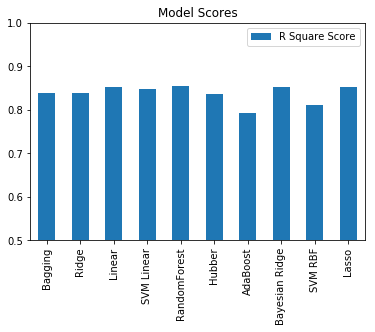

In [12]:
# Split traing and test
train_ = data[:1460]
test_ = data[1460:]
results = lets_try(train_, labels)
print(results)
plt.show()

In [13]:
pca = PCA(whiten=True)
pca.fit(data)
variance = pd.DataFrame(pca.explained_variance_ratio_)
np.cumsum(pca.explained_variance_ratio_)[:37]

array([ 0.2248857 ,  0.40281429,  0.52425789,  0.62418823,  0.69580422,
        0.75944463,  0.8116806 ,  0.85647038,  0.89178708,  0.92273755,
        0.94898868,  0.95842727,  0.96637545,  0.97380464,  0.97971901,
        0.98501952,  0.98918839,  0.99199181,  0.99386559,  0.99520919,
        0.99611479,  0.99695667,  0.99771023,  0.99842564,  0.9989402 ,
        0.99933882,  0.99959949,  0.99978254,  0.99988174,  0.99993998,
        0.99998599,  0.99999658,  0.99999871,  0.99999943,  0.99999999,
        1.        ,  1.        ])

In [14]:
# PCA
pca = PCA(n_components=36, whiten=True)
pca = pca.fit(data)
data_pca = pca.transform(data)

In [15]:
train = data_pca[:1460]
test = data_pca[1460:]

                R Square Score
Bagging               0.720034
Ridge                 0.853826
Linear                0.853790
SVM Linear            0.858350
RandomForest          0.719023
Hubber                0.859653
AdaBoost              0.671663
Bayesian Ridge        0.853913
SVM RBF               0.791327
Lasso                 0.853862


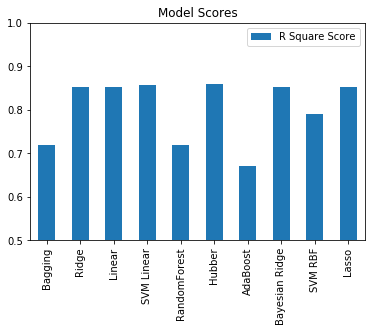

In [16]:
results = lets_try(train, labels)
print(results)
plt.show()

In [17]:
cv = KFold(n_splits=5, shuffle=True, random_state=45)
parameters = {'alpha': [1000, 100, 10], 'epsilon': [1.2, 1.25, 1.50], 'tol': [1e-10]}
clf = linear_model.HuberRegressor()
r2 = make_scorer(r2_score)
grid_obj = GridSearchCV(clf, parameters, cv=cv, scoring=r2)
grid_fit = grid_obj.fit(train, labels)
best_clf = grid_fit.best_estimator_
best_clf.fit(train, labels)

HuberRegressor(alpha=100, epsilon=1.25, fit_intercept=True, max_iter=100,
        tol=1e-10, warm_start=False)

In [18]:
labels_nl = labels
labels_nl = labels_nl.reshape(-1, 1)

In [19]:
tf.reset_default_graph()
r2 = tflearn.R2()
net = tflearn.input_data(shape=[None, train.shape[1]])
net = tflearn.fully_connected(net, 30, activation='linear')
net = tflearn.fully_connected(net, 10, activation='linear')
net = tflearn.fully_connected(net, 1, activation='linear')
sgd = tflearn.SGD(learning_rate=0.1, lr_decay=0.01, decay_step=100)
net = tflearn.regression(net, optimizer=sgd, loss='mean_square', metric=r2)
model = tflearn.DNN(net)
model.fit(train, labels_nl, show_metric=True, validation_set=0.2, shuffle=True, n_epoch=50)

Training Step: 949  | total loss: 0.01986 | time: 0.112s
| SGD | epoch: 050 | loss: 0.01986 - R2: 1.0004 -- iter: 1152/1168
Training Step: 950  | total loss: 0.01987 | time: 1.121s
| SGD | epoch: 050 | loss: 0.01987 - R2: 1.0000 | val_loss: 0.02097 - val_acc: 0.9980 -- iter: 1168/1168
--


In [20]:
predictions_huber = best_clf.predict(test)
predictions_dnn = model.predict(test)
predictions_huber = np.exp(predictions_huber)
predictions_dnn = np.exp(predictions_dnn)
predictions_dnn = predictions_dnn.reshape(-1,)

In [21]:
sub = pd.DataFrame({"Id": ids, "SalePrice": predictions_dnn})
sub.head(10)
# Saving to CSV
# sub.to_csv('submission.csv', index=False)

,Id,SalePrice
0,1461,125420.046875
1,1462,142107.062500
2,1463,188259.468750
3,1464,204987.703125
4,1465,182094.281250
5,1466,181077.593750
6,1467,172872.468750
7,1468,165140.062500
8,1469,192876.531250
9,1470,114063.898438
